# CS156 Assignment 5   
# Fraud: A how-to guide
### Yuhao Chen
### Fall 2019

### Part 0. Import libraries and load data

In [220]:
import pandas as pd
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [221]:
data=pd.read_csv('anonymized.csv')

# Add necessary data columns to the dataframe
data['Year']=np.array([x[5:9] for x in data.Date.values])
data['Month']=np.array([x[2:5] for x in data.Date.values])
data['Day']=np.array([x[0:2] for x in data.Date.values])
data['MonthYear']=np.array([x[2:9] for x in data.Date.values])
print(data.head())

        Date    Amount  Year Month Day MonthYear
0  25May2016  54241.35  2016   May  25   May2016
1  29May2017  54008.83  2017   May  29   May2017
2  30Jun2017  54008.82  2017   Jun  30   Jun2017
3  05Jan2017  52704.37  2017   Jan  05   Jan2017
4  23Feb2017  52704.36  2017   Feb  23   Feb2017


### Part 1. Get the number of transactions that occur in a single month.

In [222]:
# Extract the month data
X_monthyear = data.groupby('MonthYear').count()['Amount'].values.reshape(-1,1)
print('There is %i single months' % len(X_monthyear))

There is 49 single months


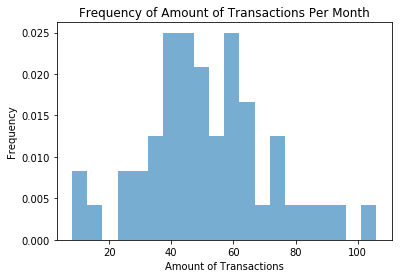

In [223]:
# show the distribution of transactions per month
plt.hist(X_monthyear,bins=20,density=1, alpha=0.6)
x_plot = np.linspace(-10,110,100)
# plt.plot(x_plot,stats.norm.pdf(x_plot,mean_monthyear,std_monthyear))
plt.legend()
plt.xlabel('Amount of Transactions')
plt.ylabel('Frequency')
plt.title('Frequency of Amount of Transactions Per Month')
plt.show()

In [224]:
# Use cross validation to get the best band width of monthyear data
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(KernelDensity(),{'bandwidth': np.linspace(0.1, 30, 30)},cv=20) # 20-fold cross-validation
grid.fit(X_monthyear)

# The best bandwidth turns out to be 10
print ('Best bandwidth for month',grid.best_params_)

Best bandwidth for month {'bandwidth': 10.410344827586206}


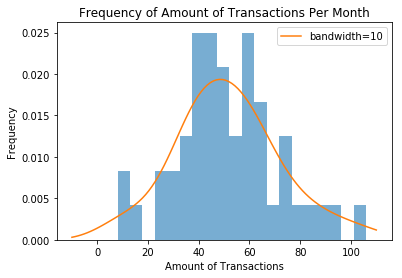

In [225]:
# Draw graph to show density model and the generated kernel density estimation curve
plt.figure()
plt.hist(X_monthyear,bins=20,density=1, alpha=0.6)
x_plot = np.linspace(-10,110,100)

# Training for kernel density estimation
kde_monthyear = KernelDensity(kernel='gaussian', bandwidth=10).fit(X_monthyear)
log_dens = kde_monthyear.score_samples(x_plot.reshape(-1,1))
plt.plot(x_plot, np.exp(log_dens), '-', label="bandwidth=10")

plt.legend()
plt.xlabel('Amount of Transactions')
plt.ylabel('Frequency')
plt.title('Frequency of Amount of Transactions Per Month')
plt.show()

### Part 2. Get the day in the month that a transaction will occur on

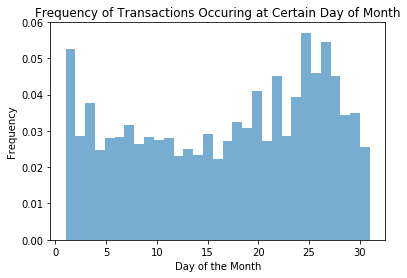

In [226]:
# Plot the data for distribution of number of transactions in each day of a month
X_day = data['Day'].astype(int)
plt.hist(X_day, bins = 31, density=1, alpha=0.6)
plt.title('Frequency of Transactions Occuring at Certain Day of Month')
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')
plt.show()

In [227]:
# Use cross-validation to get the best bandwidth for the model
# However, the model does not converge. Therefore, we just choose bandwidth = 1 after trails, since it is a reasonable value due to the graph
grid = GridSearchCV(KernelDensity(),{'bandwidth': np.linspace(0.001, 30, 100)},cv=20) # 20-fold cross-validation
grid.fit(np.array(X_day).reshape(-1,1))
print ('Best bandwidth for day',grid.best_params_)

Best bandwidth for day {'bandwidth': 0.001}


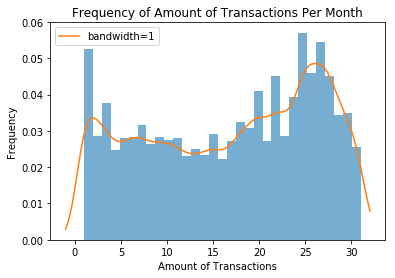

In [228]:
# Draw the Frequency of Amount of Transactions Per Month so that we know the probability to choose each day
plt.hist(X_day,bins=31,density=1, alpha=0.6)
x_plot = np.linspace(-1,32,100)

# Training for kernel density estimation
kde_day = KernelDensity(kernel='gaussian', bandwidth=1).fit(np.array(X_day).reshape(-1,1))
log_dens = kde_day.score_samples(x_plot.reshape(-1,1))
plt.plot(x_plot, np.exp(log_dens), '-', label="bandwidth=1")

plt.legend()
plt.xlabel('Amount of Transactions')
plt.ylabel('Frequency')
plt.title('Frequency of Amount of Transactions Per Month')
plt.show()

### Part 3. Get the transaction size

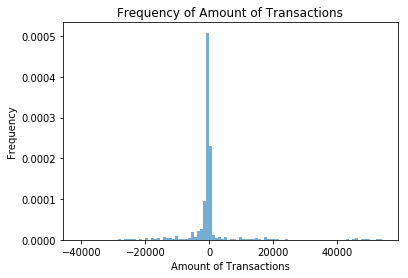

In [229]:
# Plot the distribution of amount of transactions for amount generation
plt.hist(X_amount,bins=100,density=1, alpha=0.6)
plt.title('Frequency of Amount of Transactions')
plt.xlabel('Amount of Transactions')
plt.ylabel('Frequency')
plt.show()

In [230]:
# Use cross validation to get the best bandwidth
# The model also fail to converge. For this model, we will just use 30, since it looks to be a good value from the graph.
grid = GridSearchCV(KernelDensity(),{'bandwidth': np.linspace(0.1, 100, 100)},cv=20) # 20-fold cross-validation
grid.fit(X_amount)
print ('Best bandwidth for amount',grid.best_params_)

Best bandwidth for amount {'bandwidth': 100.0}


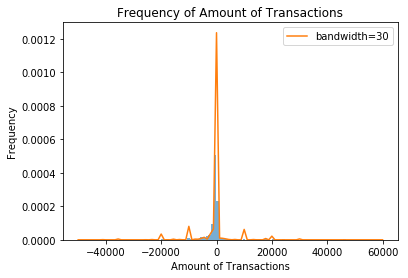

In [231]:
# Draw graph to show density model and the generated kernel density estimation curve
X_amount = data['Amount'].values.reshape(-1,1)
plt.hist(X_amount,bins=100,density=1, alpha=0.6)
x_plot = np.linspace(-50000,60000,100)

# Training for kernel density estimation
kde_amount = KernelDensity(kernel='gaussian', bandwidth=30).fit(X_amount)
log_dens = kde_amount.score_samples(x_plot.reshape(-1,1))
plt.plot(x_plot, np.exp(log_dens), '-', label="bandwidth=30")
plt.title('Frequency of Amount of Transactions')
plt.xlabel('Amount of Transactions')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Part 4. Create a fictitious month

In [232]:
# Define a function which used to generate fictitious data. It will return a dataframe containing the trade record of 1 month
def fictitious_month_generator(random_state=0):
    transaction_num = int(kde_monthyear.sample(1,random_state)[0][0])
    fict_data = []
    for transaction in range(transaction_num):
        tran_record=[]
        day = int(round(kde_day.sample(1)[0][0]))
        if day<1:
            tran_record.append(1)
        elif day>31:
            tran_record.append(31)
        else:
            tran_record.append(day)
        tran_record.append(round(kde_amount.sample(1)[0][0],2))
        fict_data.append(tran_record)
        result_df=pd.DataFrame(fict_data, columns=['Day','Amount'])
        result_df.sort_values(by=['Day'], inplace=True)
        result_df = result_df.reset_index(drop=True)
    return result_df
    

In [233]:
# Generate a dataframe of fictitious data
fictitious_month_generator()

,Day,Amount
0,1,23987.93
1,4,-283.37
2,7,-80.28
3,7,-2986.29
4,7,-252.98
5,8,-129.31
6,10,-178.22
7,12,-245.74
8,16,10014.59
9,19,-26.07


### Part 5. Flaws of the generated data

The flaws of the generated data are:
1. We consider each month to be the same, without considering the difference in transaction numbers in different month. For example, the transactions in January might be obviously more than the number in June, since there are more trades at the end or at the start of a year. Therefore, if we generate a large amount of data, the distribution of transactions over month will be a uniform distribution. However, it is not in real-world case.
2. We assume that there will be the no difference within 7 continuously days. However, due to common sense, we know there will also be weekdays and weekends in continuously 7 days. Meanwhile, people are more likely to transfer money in weekends. However, when checking my fake data and generate a large enough dataset, the weekends and weekdays will have the similar amount of transactions, which is abnormal in real-world.
3. For certain month, there will not be 29th, 30th, 31rd of the month. Therefore, need to change a little when applying on certain months.

### Part 6. Benford's Law Justification

In [234]:
# Draw Benford curve and distribution of fictitious data at the same plot
def draw_benford_justification(initial_digit):
    fig = plt.figure()  
    ax1 = fig.add_subplot(111) 
    x_list=[]
    y_list=[]
    for x in range(10,91):
        x_list.append(x/10)
        y_list.append(math.log(1+1/x))
    # Fake data
    ax1.bar(list(range(1,10)),initial_digit,alpha=0.5,label='Number')
    ax2 = ax1.twinx()
    # Benford curve
    plt.plot(x_list,y_list, c='red',label='BenFord')
    plt.xlabel('Initial Digit')
    plt.title("BenFord's justification on fictitious data")
    plt.legend()
    plt.show()

In [239]:
# Test Benford law on one month's fake data result
initial_digit=[0]*9
for i in fictitious_month_generator(random_state=5)['Amount']:
    initial_digit[int(str(abs(i))[0])-1]+=1
print(initial_digit)

[23, 12, 7, 9, 5, 6, 3, 3, 8]


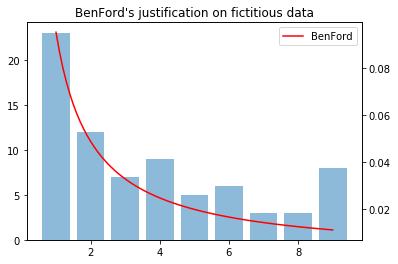

In [240]:
draw_benford_justification(initial_digit)

In [241]:
# Test Benford law on 100 months' fake data result
initial_digit=[0]*9
for k in range(100):
    for i in fictitious_month_generator(random_state=k)['Amount']:
        initial_digit[int(str(abs(i))[0])-1]+=1
print(initial_digit)

[1791, 791, 717, 609, 425, 329, 304, 236, 276]


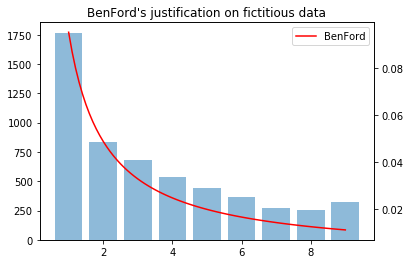

In [238]:
draw_benford_justification(initial_digit)

From the graphs, we can see that the fictitious data we generate actually follows Ben Ford Law, which shows that the data is well generated.